#Preprocessamento


In [ ]:
pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import re
import spacy
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
import copy
import seaborn as sns
import nlpaug
import nlpaug.augmenter.word as naw

In [ ]:
from torchtext.vocab import GloVe
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(name='twitter.27B', dim=50)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
df = pd.read_csv("/content/all-data.csv",encoding="ISO-8859-1", header=None)
df.columns =['label', 'text']

In [ ]:
df.label.value_counts()

neutral     2879
positive    1363
negative     604
Name: label, dtype: int64

0.0 0.0 0.0


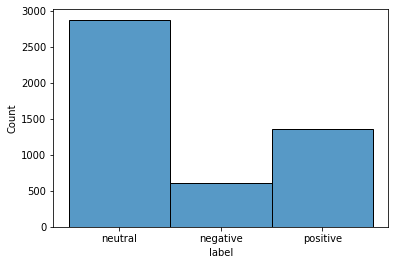

In [ ]:
sns.histplot(df, x=df.label)
print(df[df.label==0].label.count()/df.shape[0],df[df.label==1].label.count()/df.shape[0],df[df.label==2].label.count()/df.shape[0])

In [ ]:
df.label.value_counts().sort_values()

negative     604
positive    1363
neutral     2879
Name: label, dtype: int64

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet',aug_p=.3)

In [ ]:
texts_neg_sin = []
for text in df[df.label=='negative'].text:
  texts_neg_sin.extend(aug.augment(text,n=4))

In [ ]:
texts_pos_sin = []
for text in df[df.label=='positive'].text:
  texts_pos_sin.extend(aug.augment(text,n=1))

In [ ]:
new_positives = pd.DataFrame(texts_pos_sin, columns=['text'])
new_positives['label'] = 'positive'
new_positives

,text,label
0,With the new output plant the company would in...,positive
1,According to the fellowship ' siemens update s...,positive
2,funding OF ASPOCOMP ' S GROWTH Aspocomp is agg...,positive
3,"For the last quarter of 2010, Componenta ' s n...",positive
4,"In the 3rd one quarter of 2010, net sales incr...",positive
...,...,...
1358,The apartment occlusion will constitute well -...,positive
1359,"The antibody, given at repeated doses of up to...",positive
1360,Danske Savings bank Deoxyadenosine monophospha...,positive
1361,Our superscript customer centricity and expert...,positive


In [ ]:
new_negatives = pd.DataFrame(texts_neg_sin,columns=['text'])
new_negatives['label'] = 'negative'
new_negatives

,text,label
0,The external electronic industry company Elcot...,negative
1,The international electronic industry ship's c...,negative
2,The international electronic industry companio...,negative
3,The international electronic diligence company...,negative
4,A tinyurl link engage users to a scamming site...,negative
...,...,...
2411,Net sales of the Paper section decreased to EU...,negative
2412,Sales in Republic of finland decreased by 10. ...,negative
2413,Gross sales in Republic of finland lessen by 1...,negative
2414,Sales in Republic of finland fall by 10. 5% in...,negative


In [ ]:
new_df = pd.concat([df,new_negatives,new_positives],axis=0)

In [ ]:
new_df.label.loc[new_df.label=="negative"] = 0
new_df.label.loc[new_df.label=="neutral"] = 1
new_df.label.loc[new_df.label=="positive"] = 2

In [ ]:
new_df.index = [i for i in range(8625)]

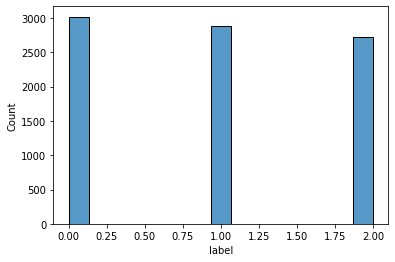

In [ ]:
sns.histplot(x=new_df.label)

In [ ]:
# re_poss = re.compile(r'\'s')
# re_clear = re.compile(r'[^a-zA-Z]+')

# new_df.text = new_df.text.apply(lambda x: re_poss.sub(" ",x)).apply(lambda x: re_clear.sub(" ",x))

In [ ]:
# nlp = spacy.load('en_core_web_sm')
# new_df.text.apply(lambda x:' '.join([w.lemma_ for w in nlp(x)]).lower(),inplace=True)

In [ ]:
new_df.label.value_counts()

0    3020
1    2879
2    2726
Name: label, dtype: int64

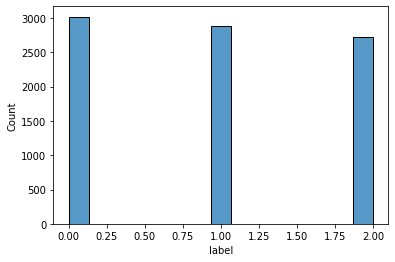

In [ ]:
sns.histplot(new_df.label)

#Modelo Dados



In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(new_df.text, new_df.label, train_size = .8)

In [ ]:
def embedding_words(data):
  emb_w = []
  for idx, line in enumerate(data):
    emb_l = global_vectors.get_vecs_by_tokens(tokenizer(line))
    result = F.pad(input = emb_l,
                  pad = (0,0,0,new_df.text.str.len().max()-emb_l.shape[0]),
                  mode = "constant",
                  value = 0)
    emb_w.append(result)
  return emb_w

In [ ]:
x_train_tensor = torch.stack(embedding_words(x_train))
y_train_tensor = torch.tensor(y_train.values.astype('int'), dtype=torch.uint8)


x_valid_tensor = torch.stack(embedding_words(x_valid))
y_valid_tensor = torch.tensor(y_valid.values.astype('int'), dtype=torch.uint8)

In [ ]:
dt_train = TensorDataset(x_train_tensor, y_train_tensor)
dt_valid = TensorDataset(x_valid_tensor, y_valid_tensor)

dl_train = DataLoader(dt_train, batch_size = 64, drop_last = True)
dl_valid = DataLoader(dt_valid, batch_size = dt_valid.tensors[0].shape[0], drop_last = True)

In [ ]:
for x, y in dl_train:
  print(x.shape, y.shape)
  break

torch.Size([64, 331, 50]) torch.Size([64])


In [ ]:
for x, y in dl_valid:
  print(x.shape, y.shape)
  break

torch.Size([1725, 331, 50]) torch.Size([1725])


#Modelo LSTM

In [ ]:
class ModeloLSTM(nn.Module):
  def __init__(self, input_size, num_hidden, num_layers):
    super().__init__()

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size,
                        num_hidden,
                        num_layers,
                        batch_first = True,
                        bidirectional = True)
    
    self.output = nn.Linear(num_hidden,3)

  def forward(self, x):
    self.lstm.flatten_parameters()

    y, (hidden, _) = self.lstm(x)
    o = self.output(hidden[-1])

    return o

In [ ]:
modelo = ModeloLSTM(input_size = 50,
                   num_hidden = 32,
                    num_layers = 2)
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelo.parameters(), lr=.001)

In [ ]:
def train_model(modelo, lossfun, optimizer):
  BestModel = {'acc':1, 'net':None}
  epochs = 100
  losses = np.zeros(epochs)

  acc_train = []
  acc_valid = []


  for epochi in range(epochs):
    modelo.to(device)
    loss_ep = []
    batch_acc = []
    modelo.train()

    for x,y in dl_train:
      x = x.to(device)
      y = y.to(device)

      y_hat = modelo(x)
      loss = lossfun(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_ep.append(loss.item())
      batch_acc.append(100*torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item())

    losses[epochi] = np.mean(loss_ep)
    acc_train.append(np.mean(batch_acc))

    modelo.cpu().eval()
    x, y = next(iter(dl_valid))
    with torch.no_grad():
      pred_y = torch.argmax(modelo(x), axis=1)
    acc_valid.append(100*torch.mean((pred_y == y).float()).item())

    if acc_valid[-1]>BestModel['acc']:
      BestModel['acc'] = acc_valid[-1]
      BestModel['net'] = copy.deepcopy(modelo.state_dict())
  
  return modelo, losses, acc_train, acc_valid, BestModel

In [ ]:
modelo, losses, acc_train, acc_valid, BestModel = train_model(modelo, lossfun, optimizer)

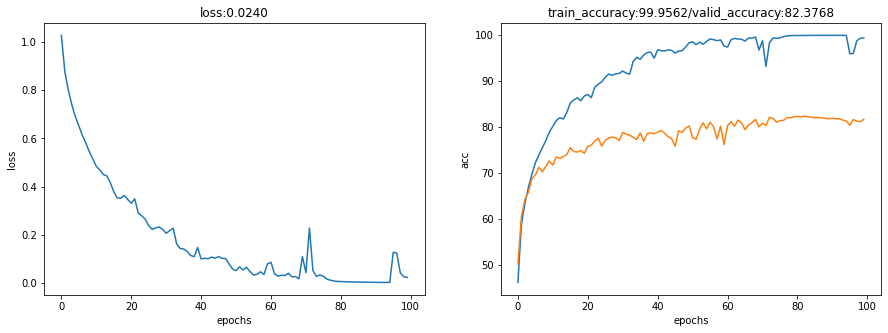

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title(f'loss:{losses[-1]:.4f}')
ax[1].plot(acc_train)
ax[1].plot(acc_valid)
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("acc")
ax[1].set_title(f'train_accuracy:{max(acc_train):.4f}/valid_accuracy:{max(acc_valid):.4f}')
plt.show()

In [ ]:
emb_l = global_vectors.get_vecs_by_tokens(tokenizer("Turkey stock market trading suspended after benchmark index falls 7%"))
result = F.pad(input = emb_l,
                pad = (0,0,0,df.text.str.len().max()-emb_l.shape[0]),
                mode = "constant",
                value = 0)
modelo(result)

tensor([-0.0937,  1.7847, -1.9180], grad_fn=<AddBackward0>)

In [ ]:
df.text[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [ ]:
emb_l = global_vectors.get_vecs_by_tokens(tokenizer(df.text[0]))
result = F.pad(input = emb_l,
                pad = (0,0,0,df.text.str.len().max()-emb_l.shape[0]),
                mode = "constant",
                value = 0)

In [ ]:
modeloCPU = modelo.cpu()

In [ ]:
modeloCPU(result)

tensor([-8.6652,  4.2214,  0.0132], grad_fn=<AddBackward0>)

In [ ]:
bestModel = ModeloLSTM(input_size = 50,
                   num_hidden = 16,
                    num_layers = 2)
bestModel.load_state_dict(BestModel['net'])

In [ ]:
torch.save(BestModel, 'nlpModel.pt')

In [ ]:
torch.save(BestModel, 'nlpFinalModel.pt')

In [ ]:
modelo = ModeloLSTM(input_size = 50,
                   num_hidden = 32,
                    num_layers = 2)

modelo.load_state_dict(torch.load("/content/nlpModel (2).pt")['net'])

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
for x, y in dl_valid:
  y_unique = y.unique()
  y_hat = modelo(x)
  cm = confusion_matrix(y, torch.argmax(y_hat.detach(),axis=1),labels = y_unique)

disp = ConfusionMatrixDisplay(cm)

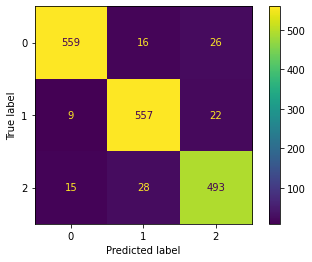

In [ ]:
disp.plot()

#ModeloFinal

In [ ]:
x_Final = torch.stack(embedding_words(new_df.text))
y_Final = torch.tensor(new_df.label.values.astype('int'), dtype=torch.uint8)

In [ ]:
dt_Final = TensorDataset(x_Final, y_Final)

dl_Final = DataLoader(dt_Final, batch_size = 64, drop_last = True, shuffle=True)

In [ ]:
next(iter(dl_Final))[0].shape

torch.Size([64, 331, 50])

In [ ]:
def train_model(modelo, lossfun, optimizer):
  BestModel = {'acc':1, 'net':None}
  epochs = 50
  losses = np.zeros(epochs)

  acc_train = []

  for epochi in range(epochs):
    modelo.to(device)
    loss_ep = []
    batch_acc = []

    for x,y in dl_Final:
      x = x.to(device)
      y = y.to(device)

      y_hat = modelo(x)
      loss = lossfun(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_ep.append(loss.item())
      batch_acc.append(100*torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item())

    losses[epochi] = np.mean(loss_ep)
    acc_train.append(np.mean(batch_acc))

    if acc_train[-1]>BestModel['acc']:
      BestModel['acc'] = acc_train[-1]
      BestModel['net'] = copy.deepcopy(modelo.state_dict())
  
  return modelo, losses, acc_train, BestModel

In [ ]:
modeloFinal = ModeloLSTM(input_size = 50,
                   num_hidden = 32,
                    num_layers = 2)
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modeloFinal.parameters(), lr=.001)

In [ ]:
modeloFinal, losses, acc_train, BestModel = train_model(modeloFinal, lossfun, optimizer)

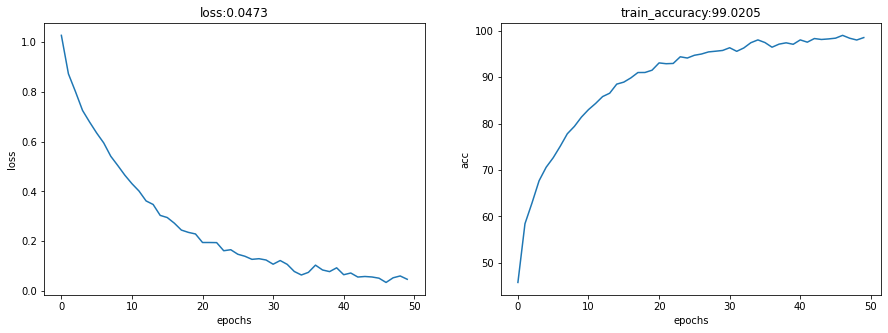

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title(f'loss:{losses[-1]:.4f}')
ax[1].plot(acc_train)
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("acc")
ax[1].set_title(f'train_accuracy:{max(acc_train):.4f}')
plt.show()

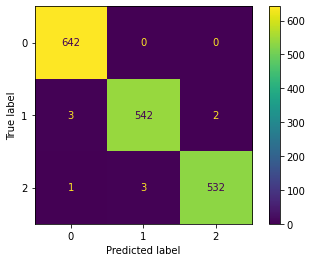

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
for x, y in dl_valid:
  y_unique = y.unique()
  y_hat = modeloFinal.cpu()(x)
  cm = confusion_matrix(y, torch.argmax(y_hat.detach(),axis=1),labels = y_unique)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
emb_l = global_vectors.get_vecs_by_tokens(tokenizer("bitcoin price keeps falling"))
result = F.pad(input = emb_l,
                pad = (0,0,0,new_df.text.str.len().max()-emb_l.shape[0]),
                mode = "constant",
                value = 0)
modeloFinal(result)

tensor([ 4.3239, -0.3051, -3.3746], grad_fn=<AddBackward0>)

In [ ]:
modeloTest = ModeloLSTM(input_size = 50,
                   num_hidden = 32,
                    num_layers = 2)
modeloTest.load_state_dict(torch.load("/content/nlpModel (2).pt")['net'])

<All keys matched successfully>

In [ ]:
modeloTest(result)

tensor([ 0.1655,  2.1280, -1.3987], grad_fn=<AddBackward0>)

#CNN-LSTM ????

In [ ]:
class ModeloLSTM(nn.Module):
  def __init__(self, input_size, num_hidden, num_layers):
    super().__init__()

    self.conv1 = F.conv2d(1,)
    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size,
                        num_hidden,
                        num_layers,
                        batch_first = True,
                        bidirectional = True)
    
    self.output = nn.Linear(num_hidden,3)

  def forward(self, x):
    self.lstm.flatten_parameters()

    y, (hidden, _) = self.lstm(x)
    o = self.output(hidden[-1])

    return o